# Test Notebook to learn how to do statistics on GPS data

### Some sources of stats info



____

### Load in some modules

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tidegauge_functions import read_GPS_SONEL, read_GPS_nam14_UNAVCO, calc_rolling_decomposition_GPS

%matplotlib inline

### Specify directories and filenames
and other runtime options

In [2]:
dir_in = 'data/GPS'
site = 'KULU'
file_in = '.cwu'
datum = '.nam14'
ext = '.csv'
filepath = os.path.join(dir_in, site + file_in + datum + ext)
print(filepath)
df = read_GPS_nam14_UNAVCO(filepath)
df

data/GPS/KULU.cwu.nam14.csv


,North,East,Vertical,NorthSTD,EastSTD,VerticalSTD,Quality
Date,,,,,,,
1996-07-25,0.00,0.00,0.00,3.08,2.19,9.93,repro
1996-07-26,-1.07,-0.16,-0.64,3.72,2.64,12.29,repro
1996-07-27,0.16,-2.04,11.45,4.15,2.93,13.92,repro
1996-07-28,-0.53,-0.65,11.62,3.05,2.19,10.03,repro
1996-07-29,-5.19,-0.85,5.00,2.90,2.07,9.80,repro
...,...,...,...,...,...,...,...
2019-08-09,-18.97,-54.44,142.87,2.15,1.47,7.51,suppf
2019-08-10,-19.59,-53.63,146.31,2.26,1.54,7.76,suppf
2019-08-11,-19.04,-53.98,150.46,2.28,1.52,7.57,suppf


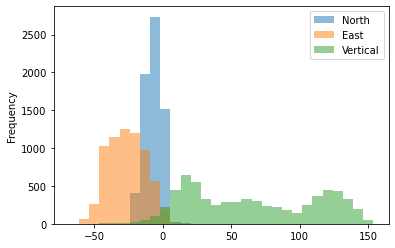

In [3]:
df[['North', 'East', 'Vertical']].plot.hist(alpha=0.5, bins=30)

# Read in SONEL

data/GPS/dNUUK_43013M001_NGL14.neu


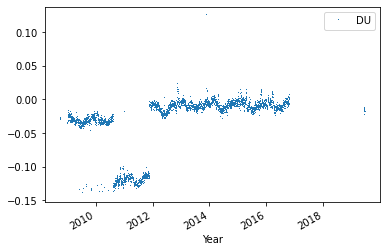

In [4]:
station = 'NUUK'
datum = 'NGL14'
ext = '.neu'
file_in = 'd' + station + '_43013M001_' + datum + ext
dir_in = 'data/GPS'
filepath = os.path.join(dir_in, file_in)
print(filepath)

df_sonel = read_GPS_SONEL(filepath)

df_sonel[['DU']].plot(linestyle='',marker=',')

# Statistics

simple correlation between different fields

In [5]:
df[['North', 'East', 'Vertical']].corr()

,North,East,Vertical
North,1.000000,0.852793,-0.876412
East,0.852793,1.000000,-0.943908
Vertical,-0.876412,-0.943908,1.000000


### Test `stationarity` using Dickey-Fuller test

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Vertical'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.4587747073166878
p-value: 0.8998133933216664
Critical Values:
	1%: -3.431333585269384
	5%: -2.8619746620810633
	10%: -2.567001367063976


These results mean we CANNOT say it IS NOT stationary (aka it is non-stationary)

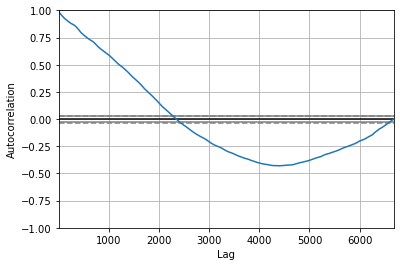

In [7]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df[['Vertical']])

This ACF plot looks like this because data is not stationary!

## Built-in `seasonal_decompose`

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


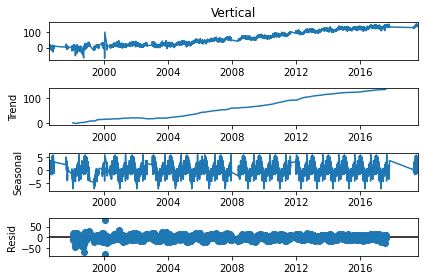

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Vertical'], freq = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


decomposition.plot();

                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 2.839e+05
Date:                Fri, 03 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:12:04   Log-Likelihood:                -20776.
No. Observations:                6318   AIC:                         4.156e+04
Df Residuals:                    6316   BIC:                         4.157e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.2322      0.163    -62.709      0.0

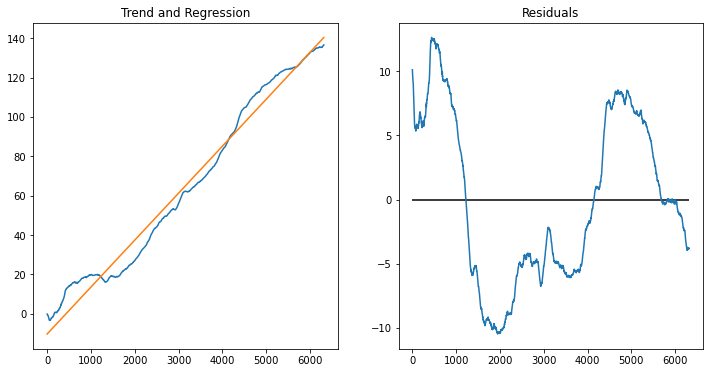

In [9]:
# trend.plot()

x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()
print(res.summary())

fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
# ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='k');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

## Rolling Mean

### test Justin's moving average function

In [24]:
df = calc_rolling_decomposition_GPS(df)

NameError: name 'calc_rolling_decomposition_GPS' is not defined

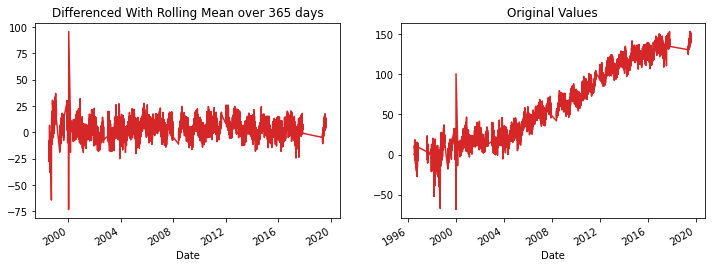

In [10]:
df_rolling = df['Vertical'].rolling(window = 365).mean()
df_detrended = df['Vertical'] - df_rolling

ax1 = plt.subplot(121)
df_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 365 days", ax=ax1);

ax2 = plt.subplot(122)
df['Vertical'].plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Dickey-Fuller test on DETRENDED data

THIS IS STATIONARY!


In [11]:
result = adfuller(df_detrended.dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -7.77566831747603
p-value: 8.683039627955237e-12
Critical Values:
	1%: -3.4313885722923336
	5%: -2.861998957482033
	10%: -2.5670143000387045


### Autocorrelation Function (ACF) on DETRENDED DATA

second peak at 365 days?


(0.0, 400.0)

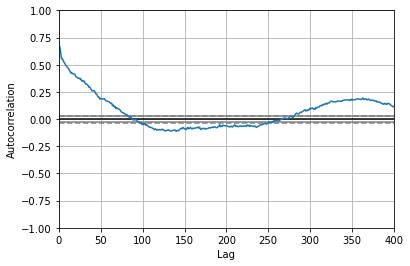

In [12]:
autocorrelation_plot(df_detrended.dropna())
plt.xlim([0, 400])

In [13]:
# from statsmodels.graphics.tsaplots import plot_acf

# plot_acf(df_detrended.dropna(), lags = 400)

## Ordinary Least Squares

                            OLS Regression Results                            
Dep. Variable:               Vertical   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 1.279e+05
Date:                Fri, 03 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:12:10   Log-Likelihood:                -25090.
No. Observations:                6682   AIC:                         5.018e+04
Df Residuals:                    6680   BIC:                         5.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9966      0.253    -51.377      0.0

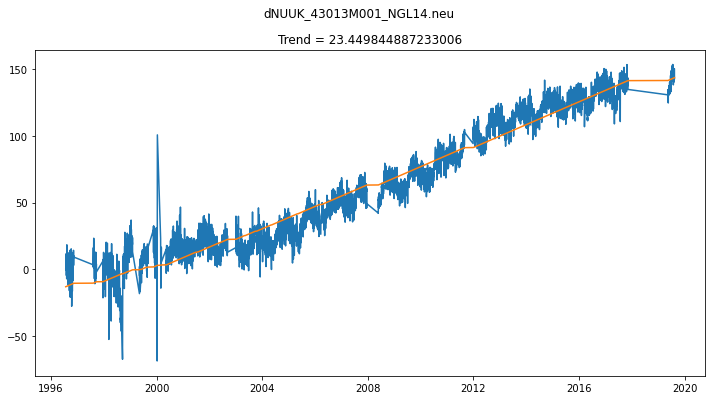

In [14]:
x, y = np.arange(len(df['Vertical'].dropna())), df['Vertical'].dropna()
x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()
print(res.summary())

fig, ax = plt.subplots(1, 1, figsize=(12,6));
ax.plot(df['Vertical'].dropna().index, df['Vertical'].dropna().values, label='trend')
ax.plot(df['Vertical'].dropna().index, [res.params.x1*i + res.params.const for i in np.arange(len(df['Vertical'].dropna()))])
# ax[1].plot(df['Vertical'].dropna().index, res.resid.values);
# ax[1].plot(df['Vertical'].dropna().index, np.abs(res.resid.values));
# ax[1].hlines(0, 0, len(res.resid), color='k');
ax.set_title(f"Trend = {res.params.x1 * 1000}");
# ax[1].set_title("Residuals");
plt.suptitle(f"{file_in}")
plt.savefig(f'figs/test_GPS_OLS_{file_in[:4]}.png')

                            OLS Regression Results                            
Dep. Variable:               Vertical   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     848.7
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          7.04e-134
Time:                        11:12:15   Log-Likelihood:                -3234.2
No. Observations:                 953   AIC:                             6472.
Df Residuals:                     951   BIC:                             6482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.7852      0.467    123.758      0.0

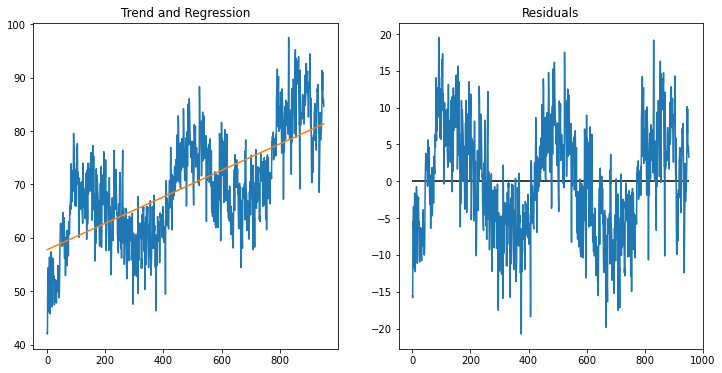

In [15]:
start_date = '2008-1-1'
end_date = '2011-1-1'

x = np.arange(len(df['Vertical'].loc[start_date:end_date].dropna())) 
y = df['Vertical'].loc[start_date:end_date].dropna()
x = sm.add_constant(x)
model = sm.OLS(y, x)
res = model.fit()
print(res.summary())

fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(df['Vertical'].loc[start_date:end_date].values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(df['Vertical'].loc[start_date:end_date].dropna()))])
ax[1].plot(res.resid.values);
# ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='k');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

# ARIMA

In [16]:
# Finding best p,q

# res = sm.tsa.arma_order_select_ic(df['Vertical'], ic=['aic', 'bic'], trend='nc')
# print(res.aic_min_order)

# result of this SLOW function is "(4, 1)"

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(df[['Vertical']].dropna(), order=(4,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Vertical   No. Observations:                 6681
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -21290.126
Method:                       css-mle   S.D. of innovations              5.857
Date:                Fri, 03 Jul 2020   AIC                          42592.252
Time:                        11:12:17   BIC                          42633.094
Sample:                             1   HQIC                         42606.358
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0213      0.030      0.707      0.480      -0.038       0.080
ar.L1.D.Vertical    -0.5667      0.012    -46.855      0.000      -0.590      -0.543
ar.L2.D.Vertical    -0.3589 

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


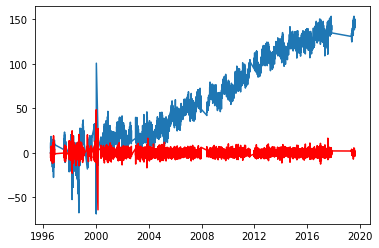

In [18]:
model = ARIMA(df['Vertical'].dropna(), order=(4, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df['Vertical'].dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


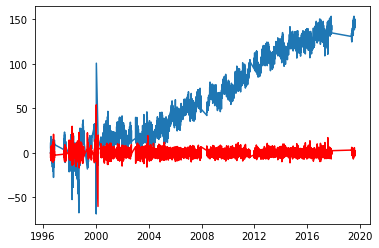

In [19]:
model = ARIMA(df['Vertical'].dropna(), order=(0, 1, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df['Vertical'].dropna())
plt.plot(results_ARIMA.fittedvalues, color='red')

# Resample to MONTHLY data

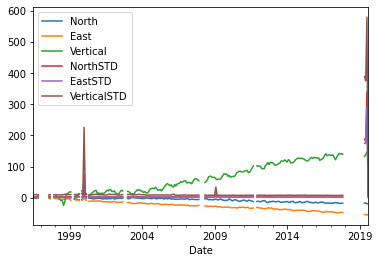

In [20]:
df_monthly = df.dropna().resample('1M').mean()
df_monthly.plot()

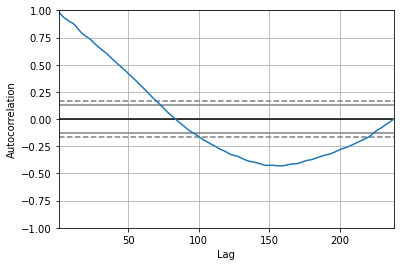

In [21]:
autocorrelation_plot(df_monthly[['Vertical']].dropna())

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(df_monthly[['Vertical']].dropna(), order=(12,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Vertical   No. Observations:                  237
Model:                ARIMA(12, 1, 0)   Log Likelihood                -676.979
Method:                       css-mle   S.D. of innovations              4.196
Date:                Fri, 03 Jul 2020   AIC                           1381.958
Time:                        11:12:26   BIC                           1430.511
Sample:                             1   HQIC                          1401.528
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5913      0.089      6.638      0.000       0.417       0.766
ar.L1.D.Vertical     -0.1228      0.065     -1.880      0.060      -0.251       0.005
ar.L2.D.Vertical     -0.

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


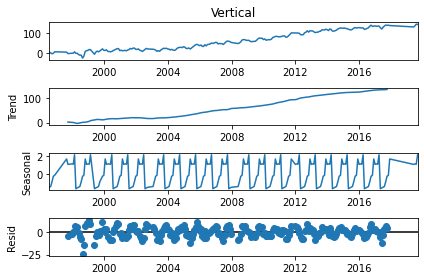

In [23]:
decomposition = seasonal_decompose(df_monthly['Vertical'].dropna(), freq = 12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


decomposition.plot();